### TF activity inference 

In [1]:
import pandas as pd
import numpy as np
import decoupler as dc
from anndata import AnnData
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2
from upsetplot import UpSet, from_contents
plt.rcParams['svg.fonttype'] = 'none'

/home/mmultari/miniconda3/envs/GRN/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


First Import dataset and filter it to match the GRN

In [2]:
GRN = pd.read_csv('Data/Network_GRN_HIVE_curated.txt',sep='\t')
GRN.rename(columns={'tf.name':'source','target.name':'target'}, inplace=True)

In [3]:
Dataset = pd.read_csv('DEA/Merge_stat_all.tsv',index_col=0, sep='\t')

In [4]:
Dataset = Dataset.reset_index()
Dataset['OLN'] = Dataset['index'].str.extract(r'(Solyc\d+g\d+)')
Dataset = Dataset.rename(columns={'index':'Gene_Name'})
Dataset.columns=Dataset.columns.str.replace('stat_','', regex=False)
Dataset = Dataset.fillna(0)

In [5]:
filtered_dataset = Dataset[Dataset['OLN'].isin(GRN['source']) | Dataset['OLN'].isin(GRN['target'])]
filtered_dataset = filtered_dataset.set_index('OLN')

In [6]:
conditions = ['Pinfestans','Cfulvum','PSTVd_S23','PSTVd_M','Bcinerea','Mincognita_7dpi','Mincognita_14dpi']

In [7]:
matrix = filtered_dataset[conditions].T

In [8]:
tf_acts, tf_pvals = dc.run_ulm(mat=matrix, net=GRN, verbose=True, weight=None)

Running ulm on mat with 7 samples and 1786 targets for 68 sources.


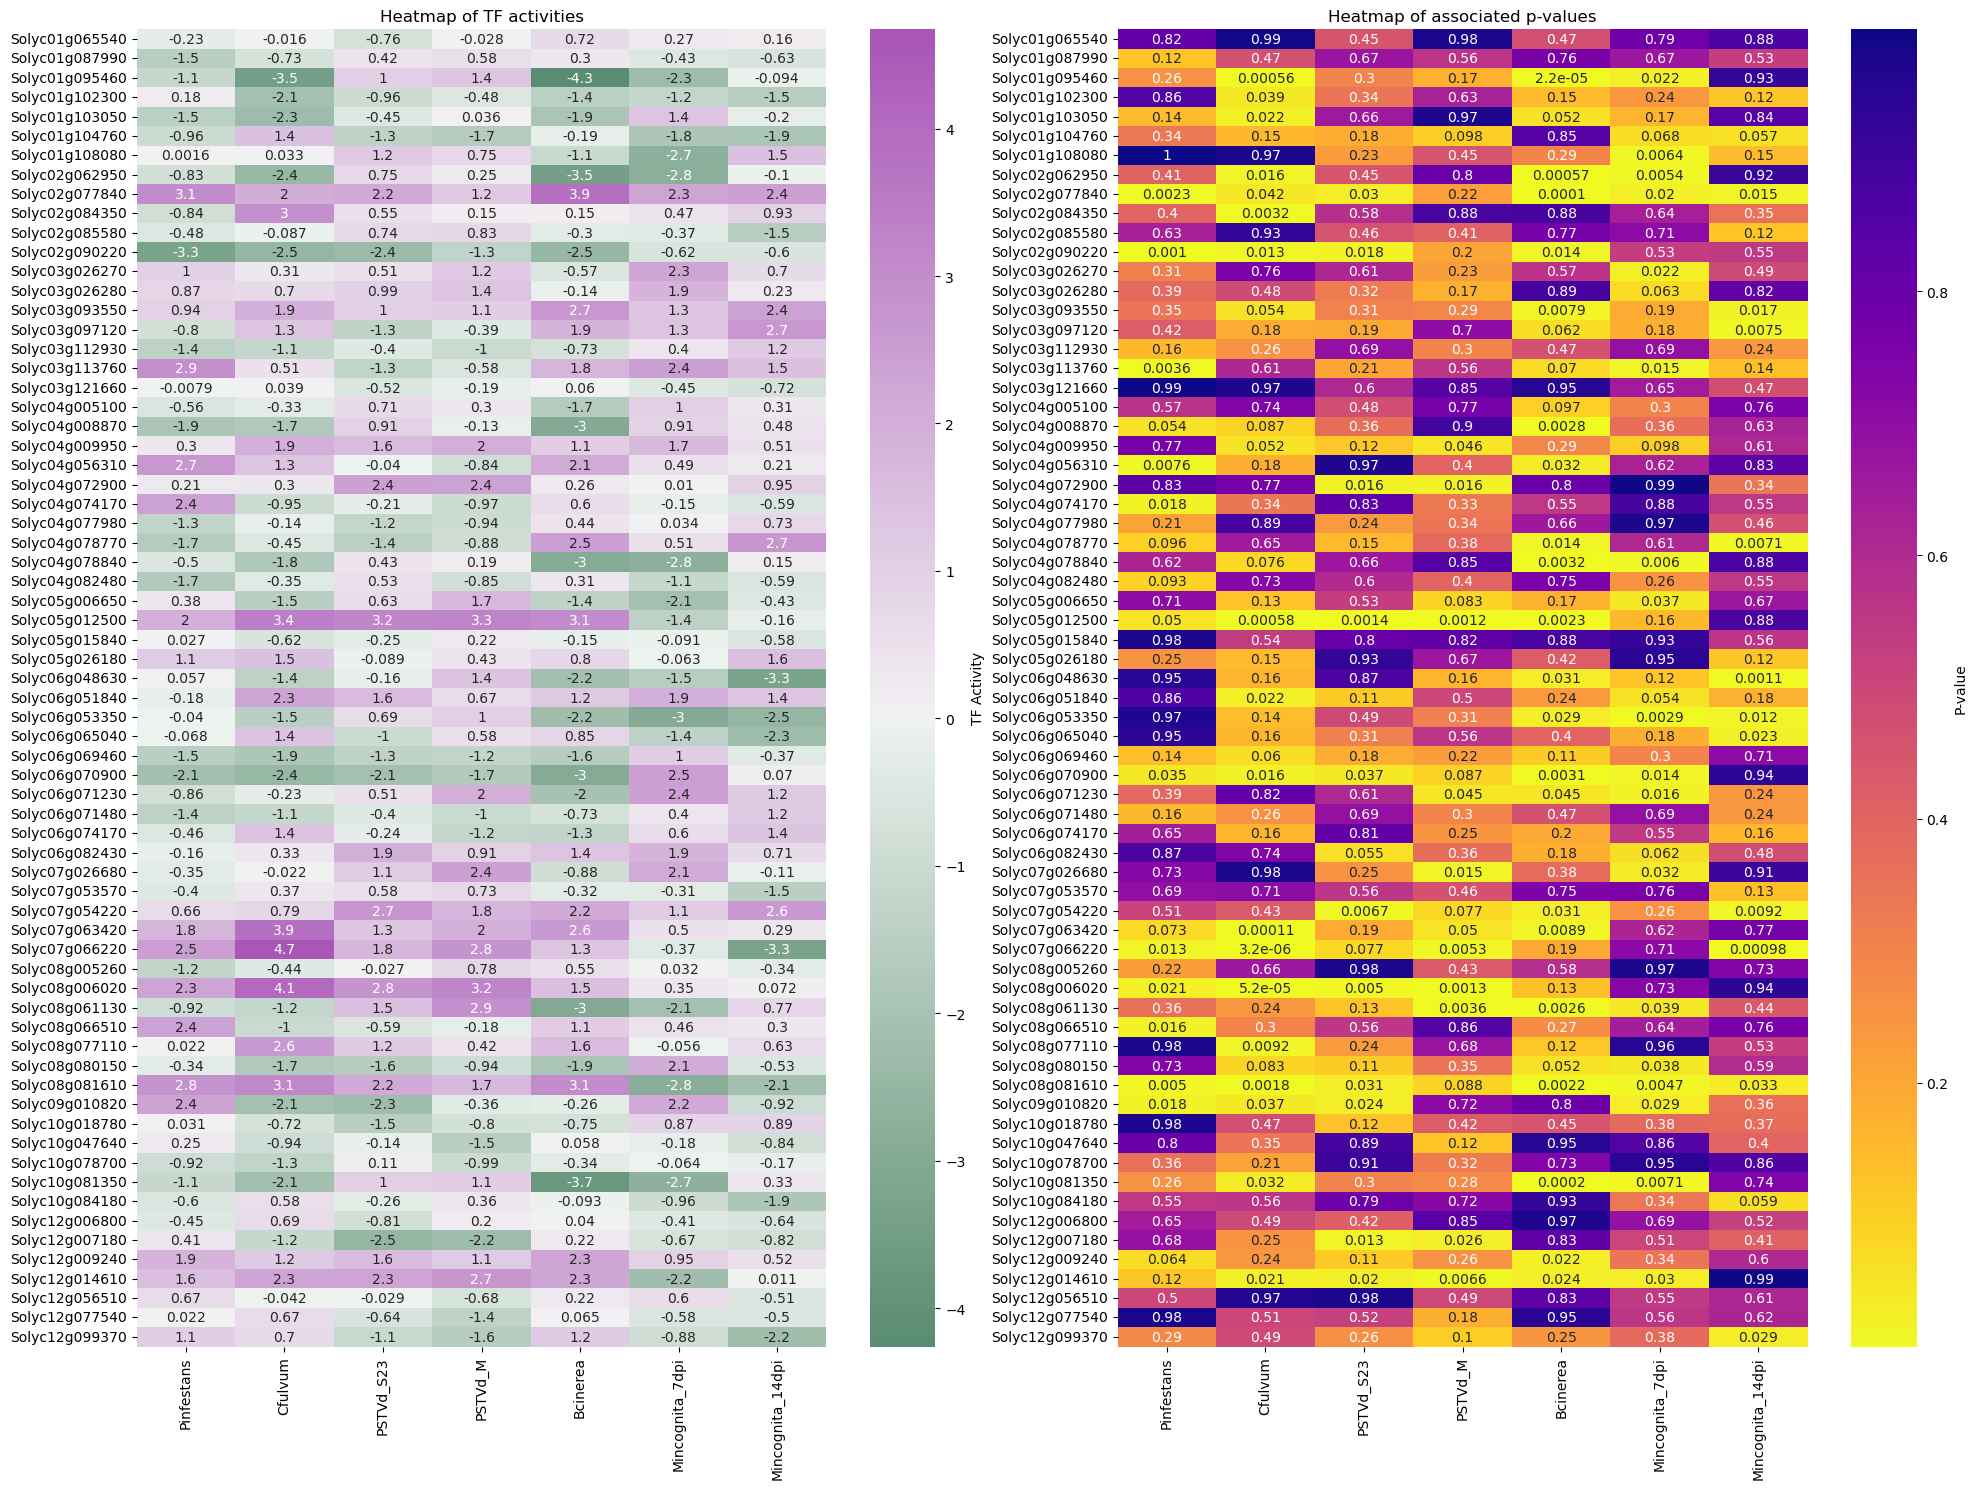

In [9]:
fig, axes = plt.subplots(1,2, figsize=(20,15), tight_layout=True)

axes[0].set_title('Heatmap of TF activities')
sns.heatmap(tf_acts.T, cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True), ax=axes[0], center=0, annot=True, cbar_kws={'label': 'TF Activity'})
axes[1].set_title('Heatmap of associated p-values')
sns.heatmap(tf_pvals.T, cmap='plasma_r', ax=axes[1], annot=True,cbar_kws={'label': 'P-value'})
# plt.savefig('./Results/Plot/Heatmap_activity_TF_all.svg', format='svg')
plt.show()

In [10]:
pvals = tf_pvals.T
acts = tf_acts.T
significant_pvals = pvals[pvals[conditions].apply(lambda x: x <= 0.05, axis=1).any(axis=1)]
# new_column_names_pvals = {col: col + '_pval' for col in significant_pvals.columns}
# significant_pvals.rename(columns=new_column_names_pvals, inplace=True)
significant_acts = acts[acts.index.isin(significant_pvals.index)]
# new_column_names_acts = {col: col + '_acts' for col in significant_acts.columns}
# significant_acts.rename(columns=new_column_names_acts, inplace=True)

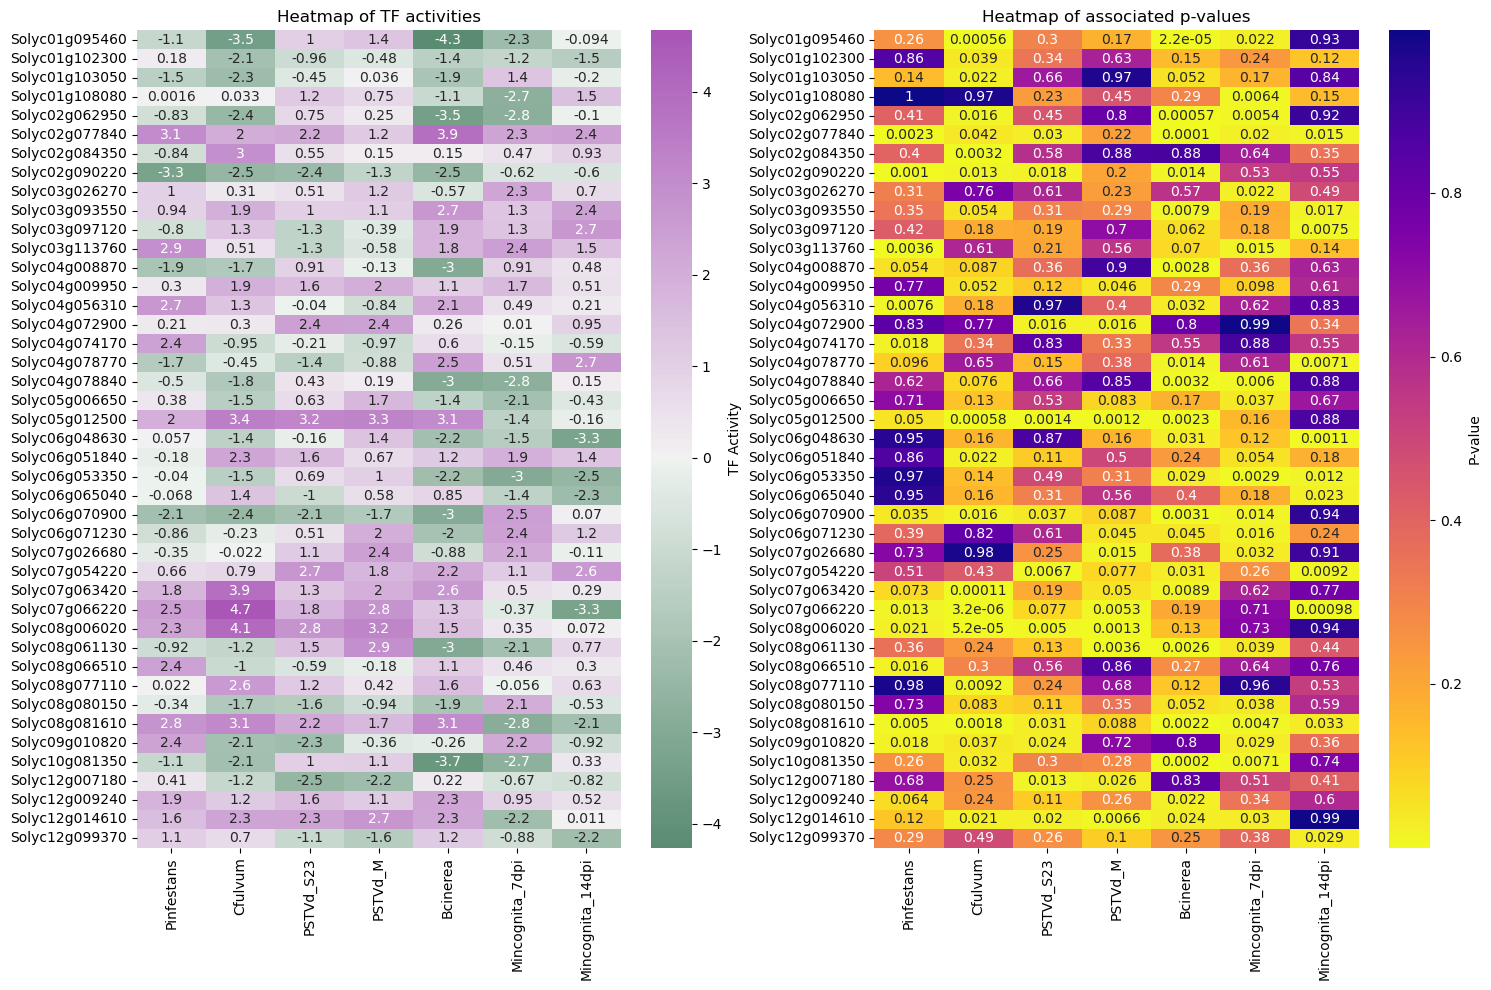

In [11]:
fig, axes = plt.subplots(1,2, figsize=(15,10), tight_layout=True)

axes[0].set_title('Heatmap of TF activities')
sns.heatmap(significant_acts, cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True), ax=axes[0], center=0, annot=True, cbar_kws={'label': 'TF Activity'})
axes[1].set_title('Heatmap of associated p-values')
sns.heatmap(significant_pvals, cmap='plasma_r', ax=axes[1], annot=True,cbar_kws={'label': 'P-value'})
# plt.savefig('./Results/Plot/Heatmap_activity_signif_TF.svg', format='svg')
plt.show()

Export the results

In [13]:
# Res_topo = pd.read_csv('Results/Result_hubs.txt',sep='\t')
# Res_topo = Res_topo.set_index('OLN')

In [14]:
pvals = tf_pvals.T
acts = tf_acts.T
# significant_pvals = pvals[pvals[conditions].apply(lambda x: x <= 0.05, axis=1).any(axis=1)]
new_column_names_pvals = {col: col + '_pval' for col in significant_pvals.columns}
pvals.rename(columns=new_column_names_pvals, inplace=True)
# significant_acts = acts[acts.index.isin(significant_pvals.index)]
new_column_names_acts = {col: col + '_acts' for col in significant_acts.columns}
acts.rename(columns=new_column_names_acts, inplace=True)

In [15]:
modified_df = filtered_dataset.copy()
modified_df.columns = [
    'stats_' + col if col in modified_df[conditions].columns else col
    for col in modified_df.columns
]

In [16]:
Tf_activity_res = pd.merge(acts, pvals, left_index=True, right_index=True)

In [17]:
def get_groups(row):
    groups = []
    cols = pvals.columns
    for col in cols:
        if row[col] <= 0.05:
            groups.append(col)
    return ' & '.join(groups) if groups else None

In [18]:
Tf_activity_res['Groups'] = Tf_activity_res.apply(get_groups, axis=1)

In [19]:
Expr_tf_activity = pd.merge(modified_df, Tf_activity_res, left_index=True, right_index=True, how='left')

In [20]:
info = pd.read_csv('Data/Network_GRN_HIVE_INFO.txt', sep='\t', index_col=0)

In [21]:
Results_merge = pd.merge(info, Expr_tf_activity, left_index=True, right_index=True)
Results_merge.index.name = 'OLN'

In [22]:
Results_merge.to_csv('Results_hubs_activity_stats.tsv',sep='\t',index=True)

In [23]:
Results_merge[Expr_tf_activity['Groups'].notnull()].shape


/tmp/ipykernel_63581/120994322.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Results_merge[Expr_tf_activity['Groups'].notnull()].shape


(43, 25)

----

---------

##### Pathway activity

Using KEGG to genes associations

In [32]:
sly_kegg = pd.read_csv('Data/KEGG_background.txt',sep='\t')
sly_kegg = sly_kegg[['gene.name','pathway.name']].drop_duplicates()
sly_kegg.rename(columns={'pathway.name':'source','gene.name':'target'}, inplace=True)

In [33]:
sly_kegg_filt = sly_kegg[sly_kegg['target'].isin(matrix.columns)]

In [34]:
sly_kegg_filt.shape

(561, 2)

In [35]:
pathway_acts, pathway_pvals = dc.run_mlm(mat=matrix, net=sly_kegg_filt, verbose=True, weight=None)

Running mlm on mat with 7 samples and 1786 targets for 27 sources.


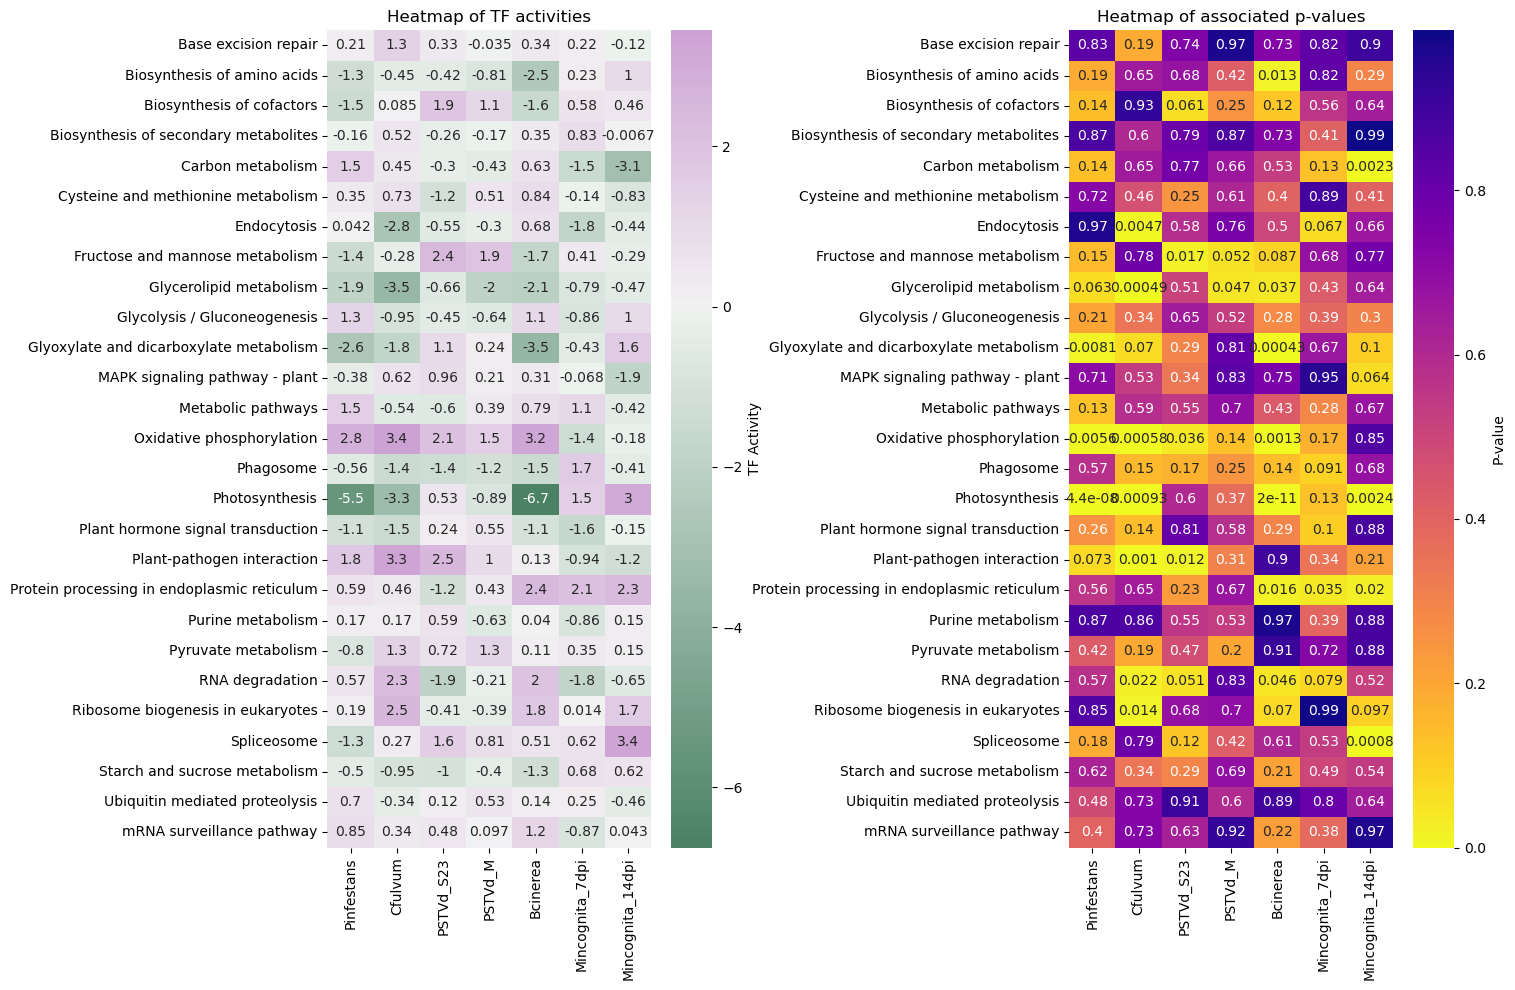

In [36]:
fig, axes = plt.subplots(1,2, figsize=(15,10), tight_layout=True)

axes[0].set_title('Heatmap of TF activities')
sns.heatmap(pathway_acts.T, cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True), ax=axes[0], center=0, annot=True, cbar_kws={'label': 'TF Activity'})
axes[1].set_title('Heatmap of associated p-values')
sns.heatmap(pathway_pvals.T, cmap='plasma_r', ax=axes[1], annot=True,cbar_kws={'label': 'P-value'})

plt.show()

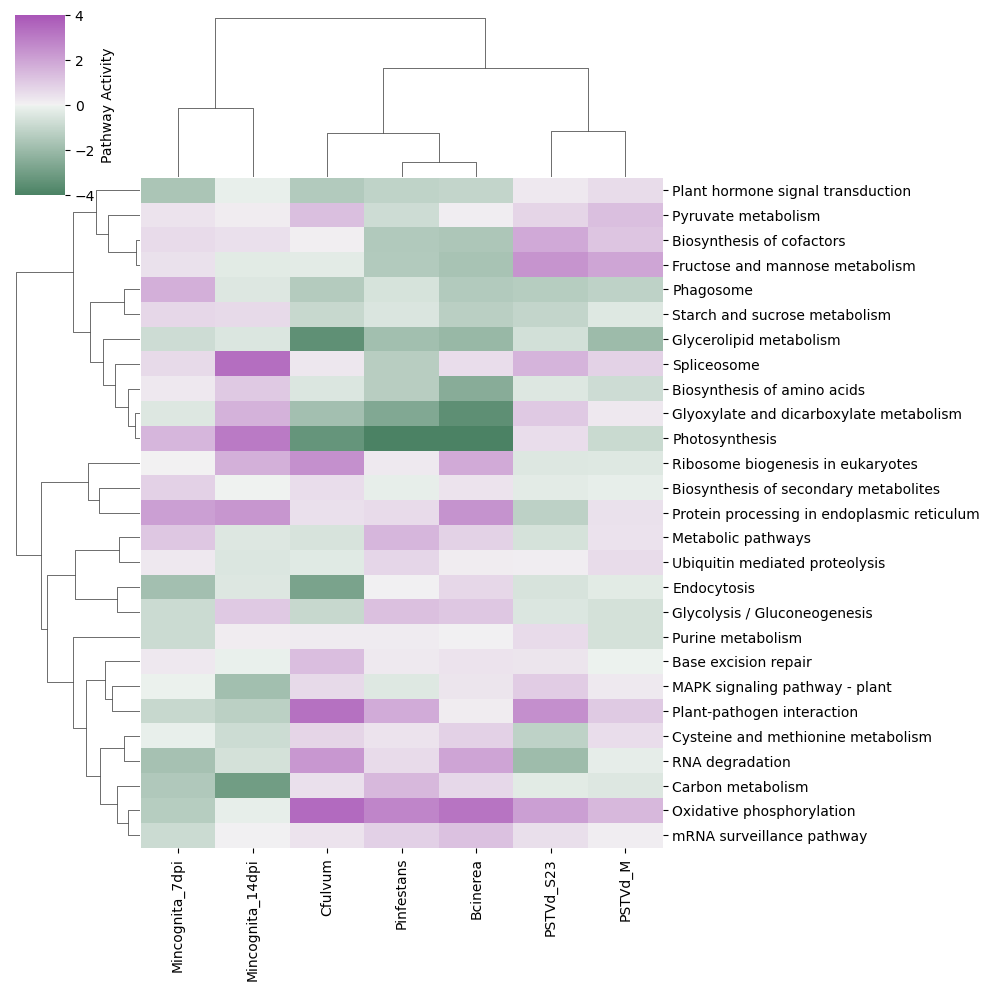

In [37]:
sns.clustermap(pathway_acts.T, 
               cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True), 
               center=0,
               cbar_kws={'label': 'Pathway Activity'}, 
               vmin = -4, 
               vmax = 4,
               method='average',
               metric='correlation')   
# plt.savefig('./Results/Clean_plot/Heatmap_activity_all_pathway.svg', format='svg')

In [38]:
pvals = pathway_pvals.T
acts = pathway_acts.T
significant_pvals = pvals[pvals[conditions].apply(lambda x: x <= 0.05, axis=1).any(axis=1)]
# new_column_names_pvals = {col: col + '_pval' for col in significant_pvals.columns}
# significant_pvals.rename(columns=new_column_names_pvals, inplace=True)
significant_acts = acts[acts.index.isin(significant_pvals.index)]
# new_column_names_acts = {col: col + '_acts' for col in significant_acts.columns}
# significant_acts.rename(columns=new_column_names_acts, inplace=True)

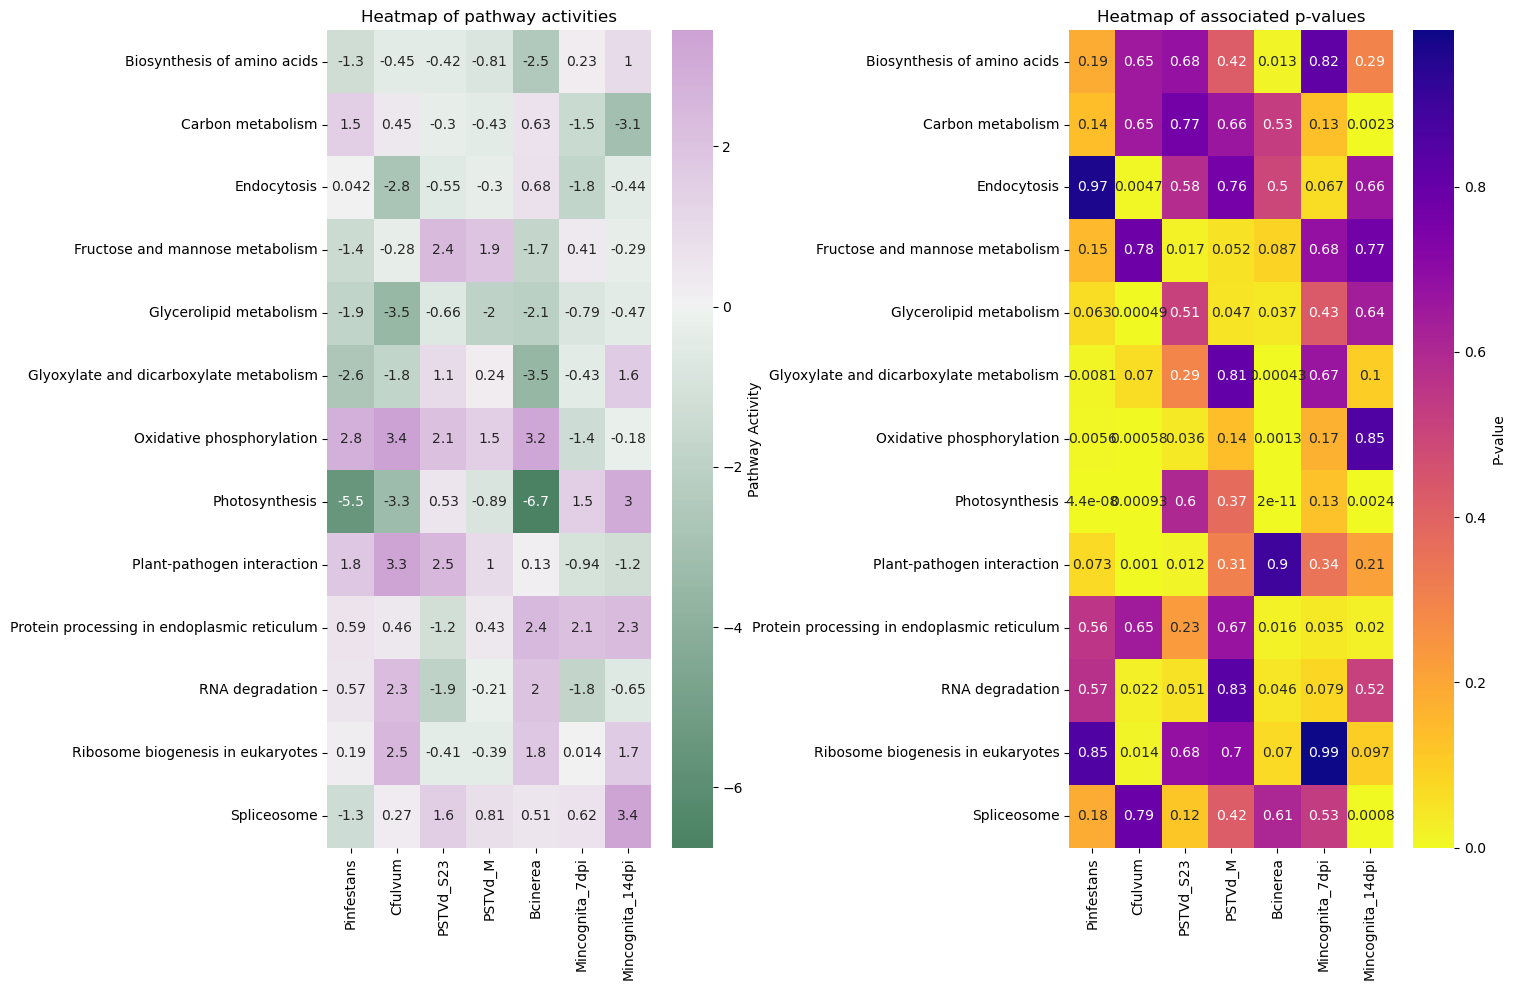

In [39]:
fig, axes = plt.subplots(1,2, figsize=(15,10), tight_layout=True)

axes[0].set_title('Heatmap of pathway activities')
sns.heatmap(significant_acts, cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True), ax=axes[0], center=0, annot=True, cbar_kws={'label': 'Pathway Activity'})
axes[1].set_title('Heatmap of associated p-values')
sns.heatmap(significant_pvals, cmap='plasma_r', ax=axes[1], annot=True,cbar_kws={'label': 'P-value'})
plt.show()

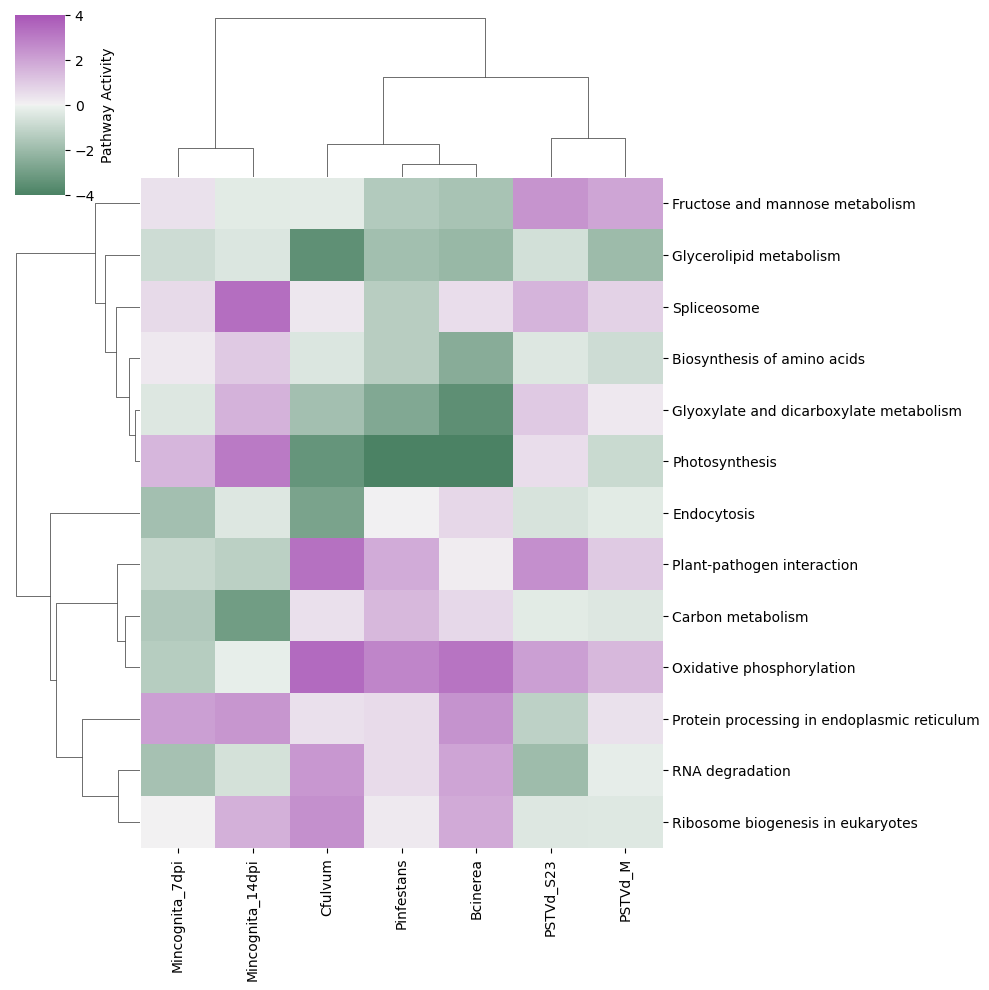

In [40]:
sns.clustermap(significant_acts, 
               cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True), 
               center=0, 
               cbar_kws={'label': 'Pathway Activity'}, 
               vmin = -4, 
               vmax = 4,
               method='average',
               metric='correlation')
plt.savefig('./Plot/Fig2_B.svg', format='svg')

In [41]:

significant_acts.iloc[:, 0:] = np.where(significant_pvals.iloc[:, 0:] <= 0.05, significant_acts.iloc[:, 0:], 0)
# significant_acts.iloc[:, 0:] = np.where(abs(significant_pvals.iloc[:, 0:]) <= 0.05, 0, significant_acts.iloc[:, 0:])
significant_acts.to_csv('Results_pathway_activity.adj',sep='\t',index=True)

/tmp/ipykernel_63581/114116269.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  significant_acts.iloc[:, 0:] = np.where(significant_pvals.iloc[:, 0:] <= 0.05, significant_acts.iloc[:, 0:], 0)


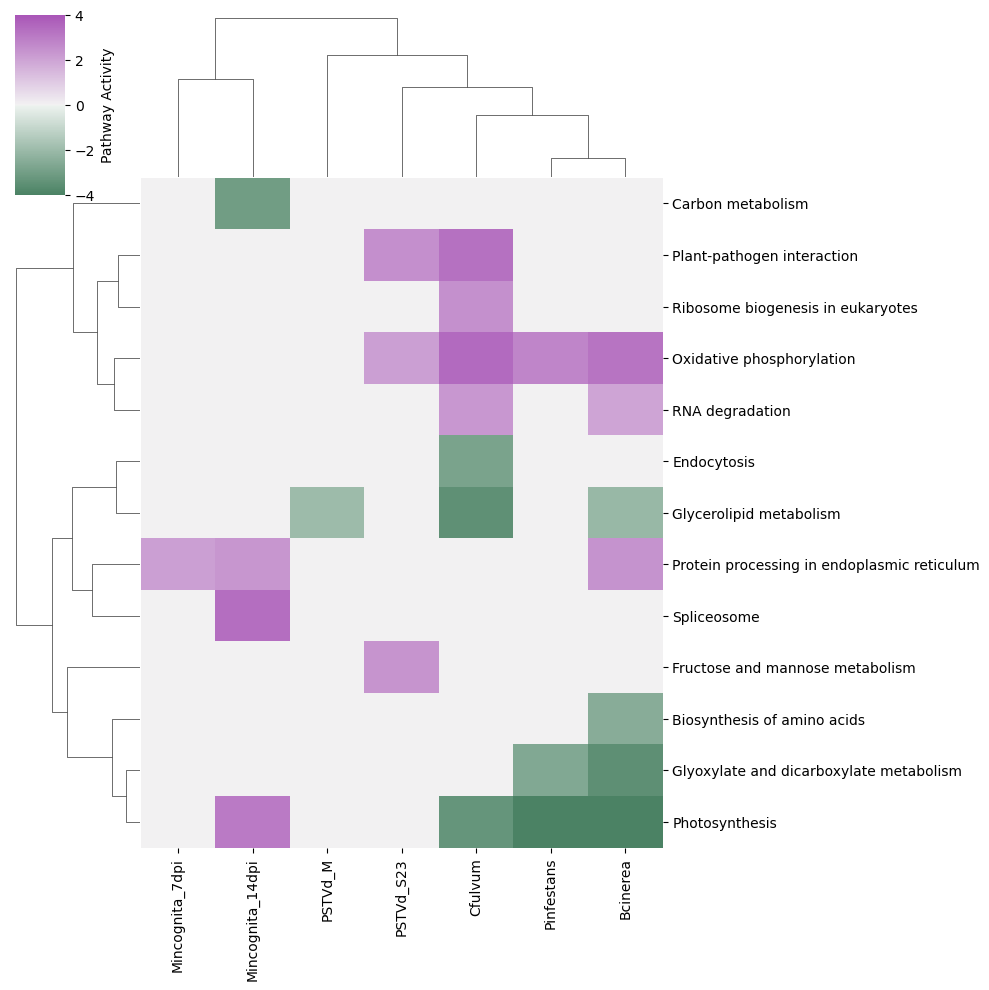

In [42]:
sns.clustermap(significant_acts, 
               cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True), 
               center=0, 
               cbar_kws={'label': 'Pathway Activity'}, 
               vmin = -4, 
               vmax = 4,
               method='average',
               metric='correlation')   

/tmp/ipykernel_63581/2500580667.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([str(abs(int(x))) for x in xticks])


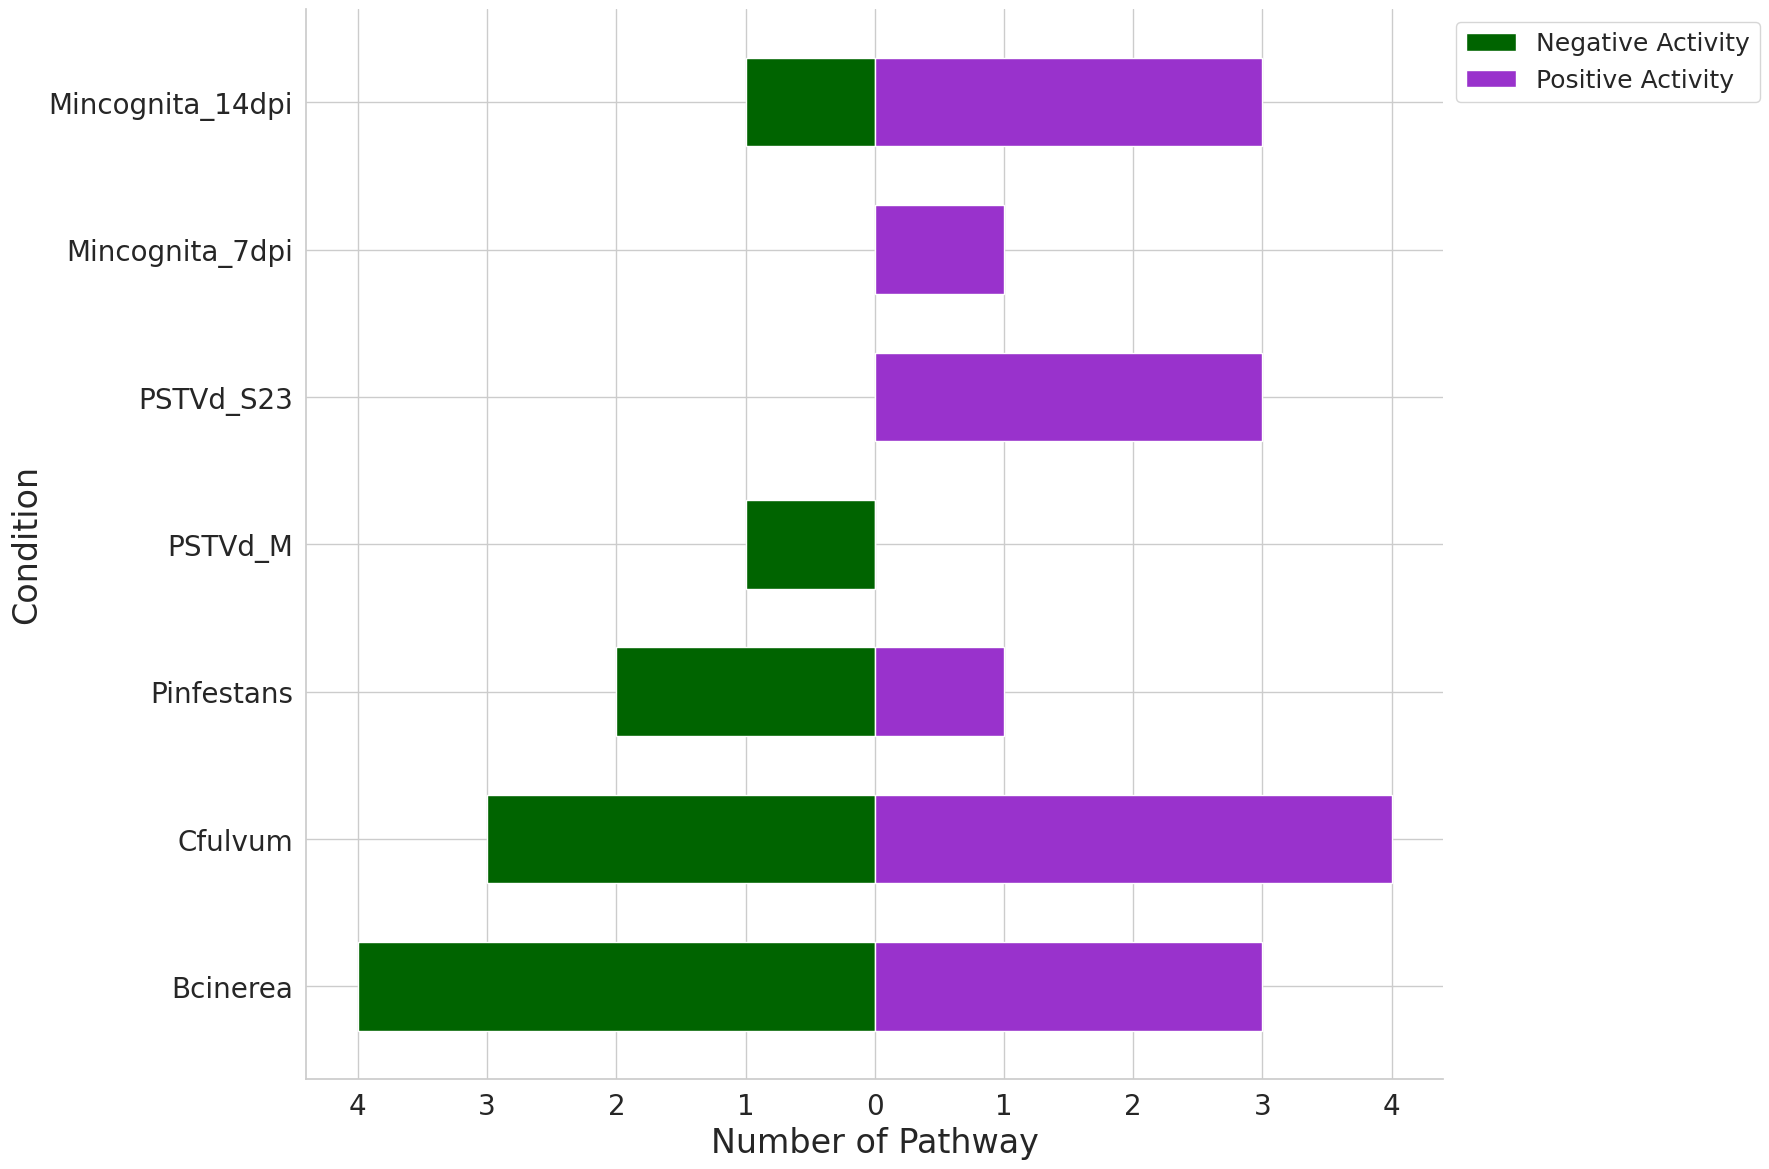

In [43]:
sns.set_theme(font_scale=1.4, style='whitegrid')
# Step 1: Convert pathway values to positive or negative counts
positive_counts = (significant_acts > 0).sum(axis=0)
negative_counts = (significant_acts < 0).sum(axis=0)

custom_order = ["Bcinerea","Cfulvum", "Pinfestans", "PSTVd_M", "PSTVd_S23", "Mincognita_7dpi", "Mincognita_14dpi"]

positive_counts = positive_counts.reindex(custom_order)
negative_counts = negative_counts.reindex(custom_order)

# Step 2: Plot butterfly plot with positive counts to the right and negative counts to the left
fig, ax = plt.subplots(figsize=(18, 12))

bar_width = 0.6  # Define the width of bars

# Plot negative values (displayed on the left side)
ax.barh(negative_counts.index, -negative_counts, color='darkgreen', label='Negative Activity', height=bar_width)

# Plot positive values (displayed on the right side)
ax.barh(positive_counts.index, positive_counts, color='darkorchid', label='Positive Activity', height=bar_width)

# Labels and title
ax.set_xlabel('Number of Pathway', fontsize=24)
xticks = ax.get_xticks()
ax.set_xticklabels([str(abs(int(x))) for x in xticks])
ax.set_ylabel('Condition', fontsize=24)
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)
ax.tick_params(axis='both', labelsize=20)

# Add a legend
ax.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=18, title_fontsize=20)

# Show the plot
plt.tight_layout()
plt.savefig('./Plot/Fig2_D.svg', format='svg')
plt.show()

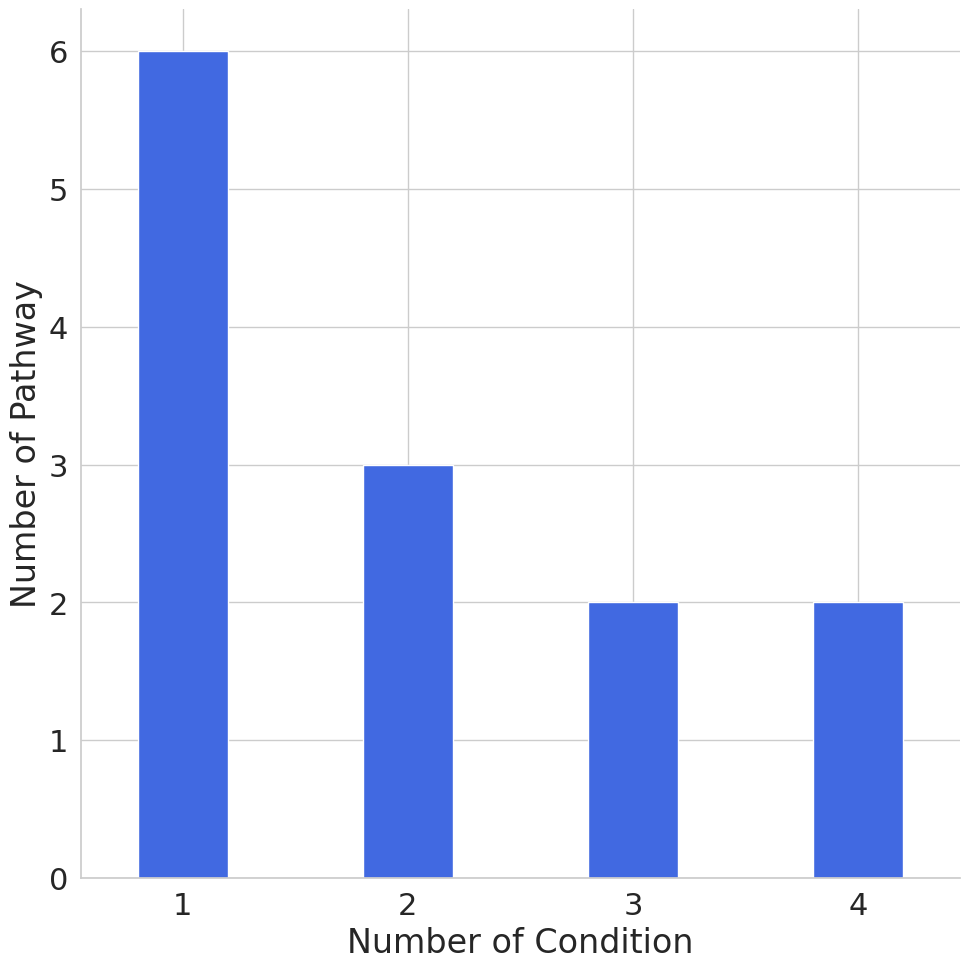

In [44]:
# Step 1: Define significance (p-value < 0.05)
significance = significant_pvals <= 0.05

# Step 2: Sum the significant pathways across all conditions
num_significant = significance.sum(axis=1)

# Step 3: Count how many pathways are significant in exactly 1, 2, ..., n conditions
significance_counts = num_significant.value_counts().sort_index()

# Step 4: Plot the results
fig, ax = plt.subplots(figsize=(10, 10))

significance_counts.plot(kind='bar', ax=ax, color='royalblue', width=0.4)

ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)
ax.tick_params(axis='both', labelsize=22)
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
# Labels and title
ax.set_xlabel('Number of Condition', fontsize=24)
ax.set_ylabel('Number of Pathway', fontsize=24)

# Show the plot
plt.tight_layout()
plt.savefig('./Plot/Fig2_C.svg', format='svg')
plt.show()

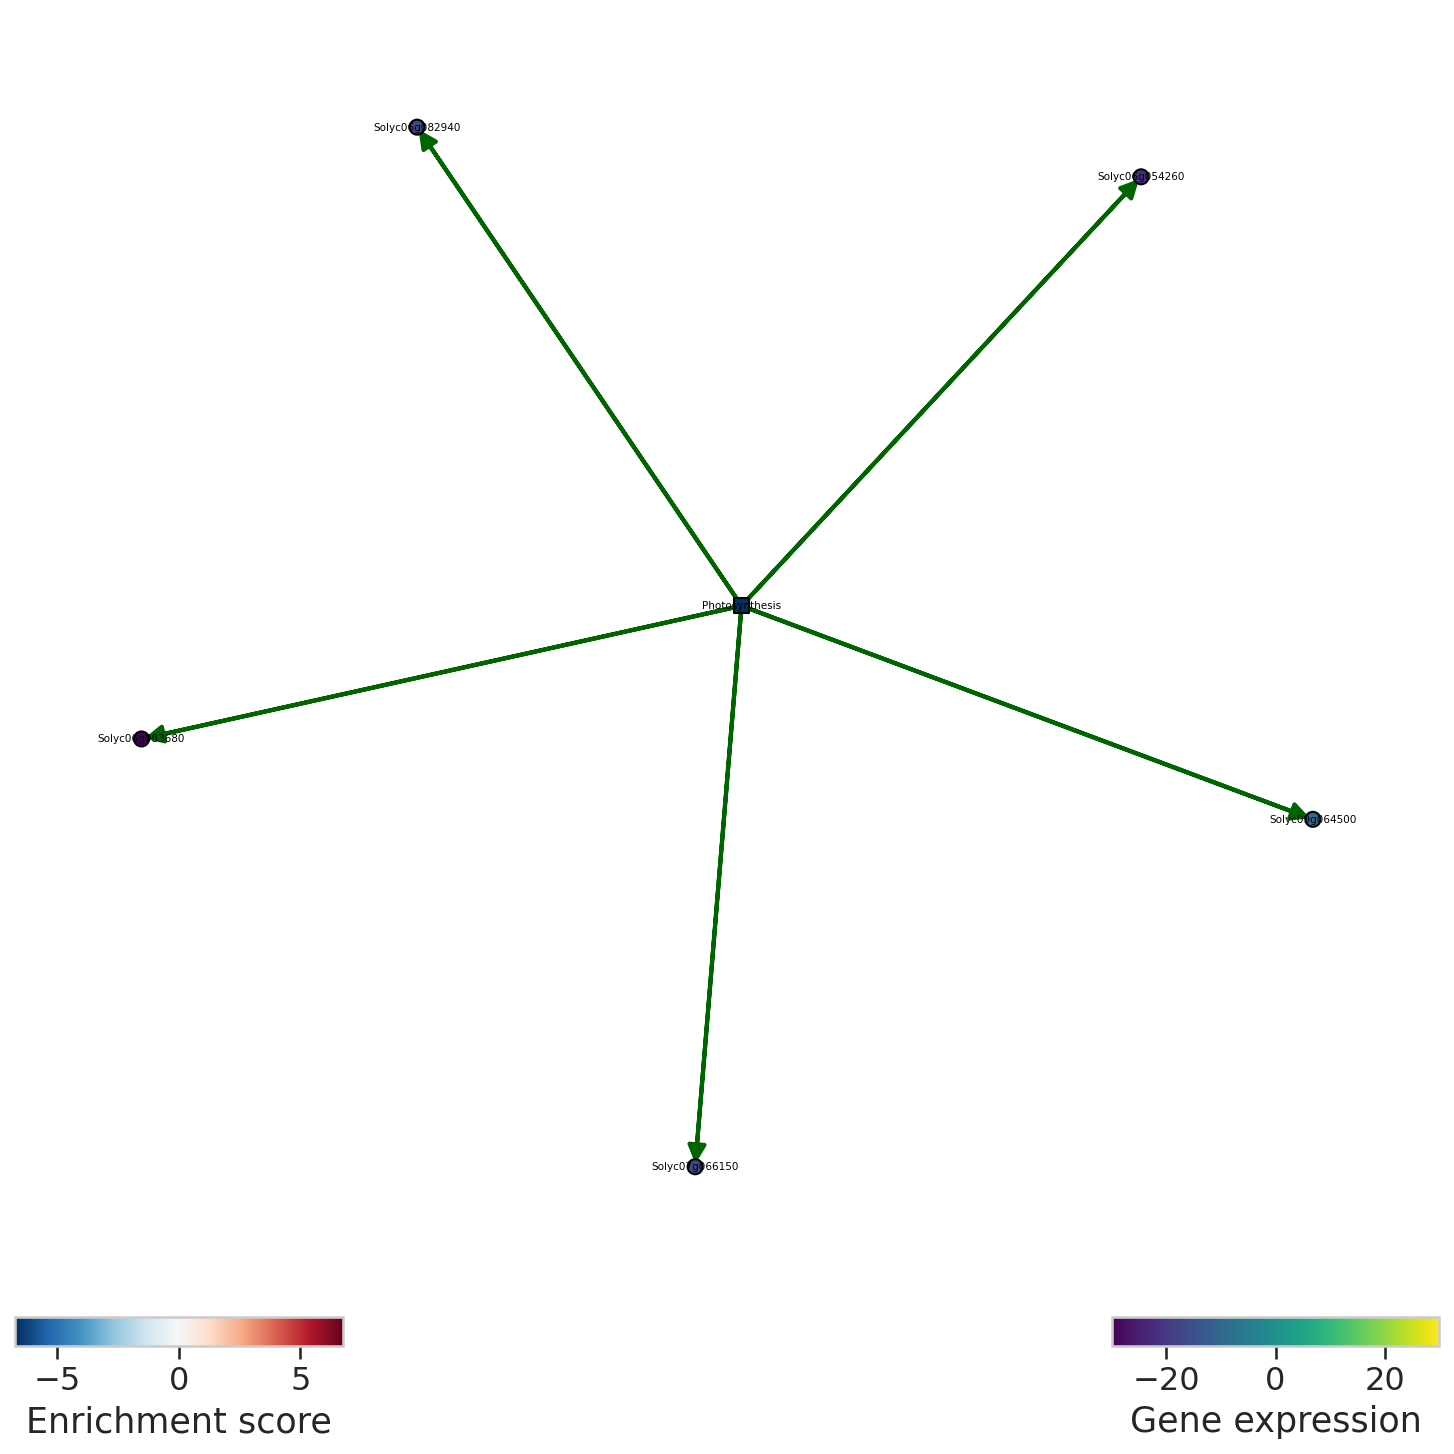

In [ ]:
# dc.plot_network(
#     net = sly_kegg_filt,
#     obs=matrix.iloc[[4], :],
#     act=pathway_acts.iloc[[4], :],
#     n_sources=['Photosynthesis'],
#     n_targets=15,
#     node_size=15,
#     figsize=(10,10),
#     c_pos_w='darkgreen',
#     c_neg_w='darkred',
#     vcenter=True
# )

In [ ]:
# import igraph as ig
# graph_global = ig.Graph.TupleList(sly_kegg[['source', 'target']].itertuples(index=False), directed=True)
# graph = ig.Graph.TupleList(sly_kegg_filt[['source', 'target']].itertuples(index=False), directed=True)

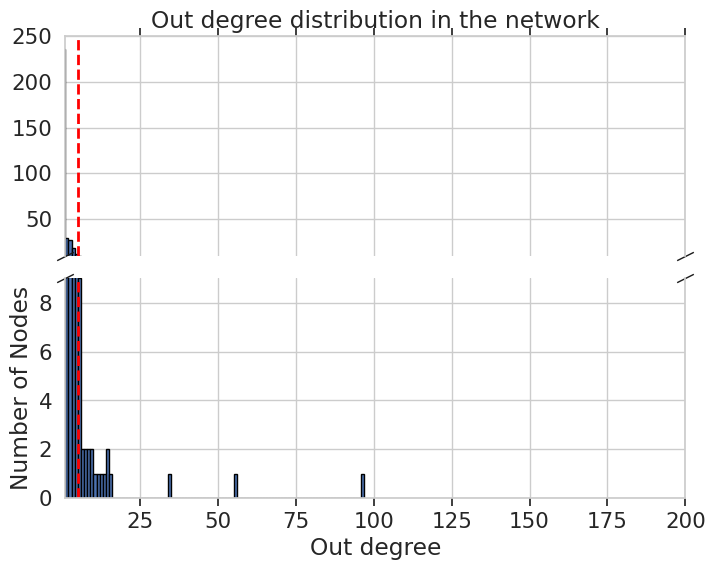

In [ ]:
# outdegree = graph.outdegree()
# bins = range(min(outdegree), max(outdegree)+1)
# fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))
# fig.subplots_adjust(hspace=0.1)  # adjust space between Axes

# # plot the same data on both Axes
# ax1.hist(outdegree, bins=bins, edgecolor='black')
# ax2.hist(outdegree, bins=bins, edgecolor='black')

# # zoom-in / limit the view to different portions of the data
# ax1.set_ylim(9, 250)  # outliers only
# ax2.set_ylim(0, 9)  # most of the data
# ax1.set_xlim(1, 200)
# ax2.set_xlim(1, 200)
# # hide the spines between ax and ax2
# ax1.spines.bottom.set_visible(False)
# ax2.spines.top.set_visible(False)
# ax1.xaxis.tick_top()
# ax1.tick_params(labeltop=False)  # don't put tick labels at the top
# ax2.xaxis.tick_bottom()

# # Now, let's turn towards the cut-out slanted lines.
# # We create line objects in axes coordinates, in which (0,0), (0,1),
# # (1,0), and (1,1) are the four corners of the Axes.
# # The slanted lines themselves are markers at those locations, such that the
# # lines keep their angle and position, independent of the Axes size or scale
# # Finally, we need to disable clipping.

# ax1.axvline(x=5, color='red', linestyle='--', linewidth=2)
# ax2.axvline(x=5, color='red', linestyle='--', linewidth=2)

# d = .5  # proportion of vertical to horizontal extent of the slanted line
# kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
#               linestyle="none", color='k', mec='k', mew=1, clip_on=False)
# ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
# ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

# ax2.set_xlabel('Out degree')
# ax2.set_ylabel('Number of Nodes')
# ax1.set_title('Out degree distribution in the network')
# plt.show()

In [ ]:
# # Get outdegree for each node
# outdegree = graph.outdegree()
# outdegree_global = graph_global.outdegree()

# # Create a DataFrame with vertex names and outdegree
# outdegree_df = pd.DataFrame({
#     "Pathway": graph.vs["name"],  # Assuming vertices have a 'name' attribute
#     "Number_GRN": outdegree,
# })
# outdegree_global_df = pd.DataFrame({
#     "Pathway": graph_global.vs["name"],  # Assuming vertices have a 'name' attribute
#     "Pathway_Size": outdegree_global,
# })
# # Remove rows where outdegree is 0
# outdegree_df = outdegree_df[outdegree_df["Number_GRN"] > 0]
# outdegree_global_df = outdegree_global_df[outdegree_global_df["Pathway_Size"] > 0]

# outdegree_df = outdegree_df.sort_values(by='Number_GRN', ascending=False)
# outdegree_global_df = outdegree_global_df.sort_values(by='Pathway_Size', ascending=False)

In [ ]:
# outdegree_global_signif_pathway = outdegree_global_df[outdegree_global_df['Pathway'].isin(significant_acts.index)]
# outdegree_grn_signif_pathway = outdegree_df[outdegree_df['Pathway'].isin(significant_acts.index)]

In [ ]:
# Info_pathway_size = pd.merge(outdegree_global_signif_pathway,outdegree_grn_signif_pathway, on='Pathway', how='inner')

In [ ]:
# Info_pathway_size['Ratio']=Info_pathway_size['Number_GRN']/Info_pathway_size['Pathway_Size']

In [ ]:
# # Step 1: Convert activity dataframe from wide to long format
# activity_df = pathway_acts.reset_index().rename(columns={"index": "Condition"})  
# activity_melted = activity_df.melt(id_vars="Condition", var_name="Pathway", value_name="Activity")

# # Step 2: Create a DataFrame for pathway outdegrees (assuming 'Vertex' column contains pathway names)
# outdegree_df = outdegree_df.rename(columns={"Vertex": "Pathway"})

# # Step 3: Merge the activity values with outdegree
# merged_df = activity_melted.merge(outdegree_df, on="Pathway", how="left")

# # Step 1: Create scatter plot with regression lines
# plt.figure(figsize=(8, 6))
# sns.lmplot(
#     data=merged_df,
#     x="Outdegree",
#     y="Activity",
#     hue="Condition",  # Different colors per condition
#     ci=False,  # Show 95% confidence interval
#     aspect=1.2,
#     height=6
# )

# # Step 2: Customize plot
# plt.xlabel("Outdegree of Pathway")
# plt.ylabel("Activity Value")
# plt.title("Correlation Between Outdegree and Activity Value per Condition")
# plt.axhline(0, color="gray", linestyle="dashed", linewidth=1)  # Add reference line at y=0
# plt.grid(True)
# plt.hlines(2, color='red', linestyles='dashed', xmin=0, xmax=40)
# plt.hlines(-2, color='red', linestyles='dashed', xmin=0, xmax=40)
# plt.vlines(5, color='red', linestyles='dashed', ymin=-4, ymax=4)
# plt.xlim(0,20)
# # Step 3: Show plot
# plt.show()

KeyError: "['Outdegree'] not in index"

<Figure size 800x600 with 0 Axes>

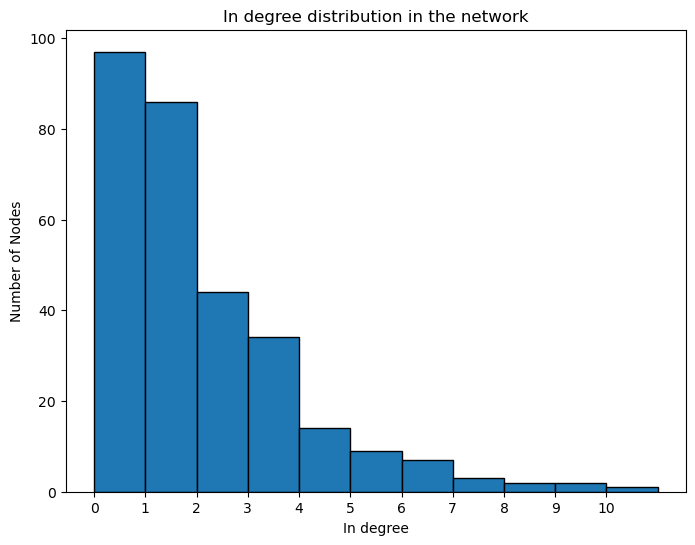

In [ ]:
# indegree = graph.indegree()
# # Calculate bin edges
# bins = range(min(graph.indegree()), max(graph.indegree()) + 2)

# # Create the histogram
# plt.figure(figsize=(8, 6))
# plt.hist(indegree, bins=bins, edgecolor='black', align='mid')

# # Set x-axis ticks to integers
# plt.xticks(range(min(graph.indegree()), max(graph.indegree()) + 1))

# # Add labels and title
# plt.xlabel('In degree')
# plt.ylabel('Number of Nodes')
# plt.title('In degree distribution in the network')
# # Show the plot
# plt.show()